## Import Libraries

In [19]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure
from scipy import stats
from skimage.feature import graycomatrix, graycoprops
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

## User Input Configuration

In [20]:
print("="*60)
print("TB DETECTION - PREDICTION CONFIGURATION")
print("="*60)

# Ask user for input type
print("\nInput Options:")
print("  1. Single image")
print("  2. Folder containing multiple images")

input_type = input("\nChoose input type (1 or 2): ").strip()

if input_type == '1':
    # Single image mode
    image_path = input("Enter path to single image: ").strip()
    image_path = Path(image_path).expanduser()
    
    if not image_path.exists():
        print(f"❌ Error: File not found - {image_path}")
        image_path = None
    else:
        print(f"✅ Single image mode: {image_path}")
    
    folder_path = None
    
elif input_type == '2':
    # Folder mode
    folder_path = input("Enter path to folder containing images: ").strip()
    folder_path = Path(folder_path).expanduser()
    
    if not folder_path.exists():
        print(f"❌ Error: Folder not found - {folder_path}")
        folder_path = None
    else:
        # Count images in folder
        image_files = list(folder_path.glob('*.png')) + list(folder_path.glob('*.jpg')) + list(folder_path.glob('*.jpeg'))
        print(f"✅ Folder mode: {folder_path}")
        print(f"   Found {len(image_files)} images")
    
    image_path = None
else:
    print("❌ Invalid choice. Please run this cell again.")
    image_path = None
    folder_path = None

# Model selection
print("\nModel Options:")
print("  1. SVM (Support Vector Machine)")
print("  2. Naive Bayes")
print("  3. Both (compare results)")

model_choice = input("\nChoose model (1, 2, or 3): ").strip()

CONFIG = {
    'input_type': input_type,
    'image_path': image_path,
    'folder_path': folder_path,
    'model_choice': model_choice
}

print("\n" + "="*60)
print("Configuration saved successfully!")
print("="*60)

TB DETECTION - PREDICTION CONFIGURATION

Input Options:
  1. Single image
  2. Folder containing multiple images
✅ Single image mode: D:\Vscode\MicrosoftVSCode\PCD\Project\image_normal.jpg

Model Options:
  1. SVM (Support Vector Machine)
  2. Naive Bayes
  3. Both (compare results)

Configuration saved successfully!


## Preprocessing Functions

In [21]:
def preprocess_image(img_path, show_steps=False):
    """
    Complete preprocessing pipeline:
    1. Load grayscale image
    2. Resize to standard size
    3. Apply Gaussian blur
    4. Apply CLAHE for contrast enhancement
    """
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None, None, None

    # Resize to standard size (512x512)
    img = cv2.resize(img, (512, 512))

    # Gaussian filtering to reduce noise
    blurred = cv2.GaussianBlur(img, (5, 5), 0)

    # CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blurred)

    return img, blurred, enhanced

## Segmentation Functions

In [22]:
def segment_lungs(enhanced_img, show_steps=False):
    """
    Segment lung regions using improved morphological operations.
    KEY IMPROVEMENT: Uses INVERTED thresholding to get dark lung regions.
    """
    if enhanced_img is None:
        return None, None, None

    # CRITICAL: Inverse Otsu to get lungs (dark areas in X-ray)
    _, binary = cv2.threshold(enhanced_img, 0, 255,
                             cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Morphological opening to remove noise
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_open, iterations=2)

    # Morphological closing to fill gaps
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_close, iterations=3)

    # Find contours and select largest regions (lungs)
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create mask
    mask = np.zeros_like(enhanced_img)

    if len(contours) > 0:
        # Sort by area and take top 2 (left and right lung)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        num_lungs = min(2, len(contours))

        for i in range(num_lungs):
            if cv2.contourArea(contours[i]) > 1000:  # Filter small regions
                cv2.drawContours(mask, [contours[i]], -1, 255, -1)

    # Final closing on mask
    kernel_final = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_final, iterations=2)

    return mask, binary, closed

## Feature Extraction Functions

In [23]:
def extract_shape_features(mask):
    """Extract geometrical features from lung region."""
    if mask is None or np.sum(mask) == 0:
        return {
            'area': 0, 'perimeter': 0, 'eccentricity': 0,
            'extent': 0, 'solidity': 0, 'major_axis': 0, 'minor_axis': 0
        }

    labeled = measure.label(mask)
    regions = measure.regionprops(labeled)

    if len(regions) == 0:
        return {
            'area': 0, 'perimeter': 0, 'eccentricity': 0,
            'extent': 0, 'solidity': 0, 'major_axis': 0, 'minor_axis': 0
        }

    # Aggregate features from all regions
    total_area = sum([r.area for r in regions])
    total_perimeter = sum([r.perimeter for r in regions])
    avg_eccentricity = np.mean([r.eccentricity for r in regions])
    avg_extent = np.mean([r.extent for r in regions])
    avg_solidity = np.mean([r.solidity for r in regions])
    avg_major = np.mean([r.major_axis_length for r in regions])
    avg_minor = np.mean([r.minor_axis_length for r in regions])

    return {
        'area': total_area,
        'perimeter': total_perimeter,
        'eccentricity': avg_eccentricity,
        'extent': avg_extent,
        'solidity': avg_solidity,
        'major_axis': avg_major,
        'minor_axis': avg_minor
    }

def extract_first_order_stats(image, mask):
    """Extract first-order statistical features."""
    if image is None or mask is None or np.sum(mask) == 0:
        return {k: 0 for k in ['mean', 'variance', 'std_dev', 'skewness',
                               'kurtosis', 'entropy', 'smoothness', 'uniformity']}

    masked_pixels = image[mask > 0]

    if len(masked_pixels) == 0:
        return {k: 0 for k in ['mean', 'variance', 'std_dev', 'skewness',
                               'kurtosis', 'entropy', 'smoothness', 'uniformity']}

    mean = np.mean(masked_pixels)
    variance = np.var(masked_pixels)
    std_dev = np.std(masked_pixels)
    skewness = stats.skew(masked_pixels)
    kurtosis = stats.kurtosis(masked_pixels)

    # Histogram-based features
    hist, _ = np.histogram(masked_pixels, bins=256, range=(0, 256), density=True)
    hist = hist[hist > 0]
    entropy = -np.sum(hist * np.log2(hist + 1e-10))
    smoothness = 1 - (1 / (1 + variance))
    uniformity = np.sum(hist ** 2)

    return {
        'mean': mean,
        'variance': variance,
        'std_dev': std_dev,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'entropy': entropy,
        'smoothness': smoothness,
        'uniformity': uniformity
    }

def extract_glcm_features(image, mask):
    """Extract GLCM texture features."""
    if image is None or mask is None or np.sum(mask) == 0:
        return {k: 0 for k in ['contrast', 'dissimilarity', 'homogeneity',
                               'energy', 'correlation', 'ASM']}

    masked_img = image.copy()
    masked_img[mask == 0] = 0

    # Check if there's meaningful data
    if np.all(masked_img == 0) or len(np.unique(masked_img)) < 2:
        return {k: 0 for k in ['contrast', 'dissimilarity', 'homogeneity',
                               'energy', 'correlation', 'ASM']}

    # Normalize to 8-bit
    img_8bit = cv2.normalize(masked_img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    # Compute GLCM
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    try:
        glcm = graycomatrix(img_8bit, distances=distances, angles=angles,
                           levels=256, symmetric=True, normed=True)

        # Extract properties
        contrast = graycoprops(glcm, 'contrast').mean()
        dissimilarity = graycoprops(glcm, 'dissimilarity').mean()
        homogeneity = graycoprops(glcm, 'homogeneity').mean()
        energy = graycoprops(glcm, 'energy').mean()
        correlation = graycoprops(glcm, 'correlation').mean()
        asm = graycoprops(glcm, 'ASM').mean()

        return {
            'contrast': contrast,
            'dissimilarity': dissimilarity,
            'homogeneity': homogeneity,
            'energy': energy,
            'correlation': correlation,
            'ASM': asm
        }
    except:
        return {k: 0 for k in ['contrast', 'dissimilarity', 'homogeneity',
                               'energy', 'correlation', 'ASM']}

def extract_all_features(img_path):
    """Extract all features from a single image."""
    # Preprocessing
    original, blurred, enhanced = preprocess_image(img_path, show_steps=False)

    if enhanced is None:
        return None, None, None

    # Segmentation
    lung_mask, binary, closed = segment_lungs(enhanced, show_steps=False)

    if lung_mask is None:
        return None, None, None

    # Feature extraction
    shape_features = extract_shape_features(lung_mask)
    stats_features = extract_first_order_stats(enhanced, lung_mask)
    glcm_features = extract_glcm_features(enhanced, lung_mask)

    # Combine all features
    all_features = {**shape_features, **stats_features, **glcm_features}

    return all_features, lung_mask, enhanced

## Model Class Definition

(Required for unpickling trained models)

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

class HierarchicalClassifier:
    """
    Hierarchical classification class - MUST match the training notebook exactly!
    Required for unpickling the trained models.
    """

    def __init__(self, model_type='svm'):
        self.model_type = model_type
        self.stage1_model = None
        self.stage2_model = None
        self.scaler1 = StandardScaler()
        self.scaler2 = StandardScaler()
        self.shape_cols = None
        self.all_cols = None
        self.is_fitted = False

    def fit(self, X, y):
        self.all_cols = X.columns.tolist()

        # Identify shape features
        self.shape_cols = [col for col in X.columns if any(
            keyword in col for keyword in ['area', 'perimeter', 'eccentricity',
                                          'extent', 'solidity', 'major', 'minor']
        )]

        X_shape = X[self.shape_cols]
        X_all = X

        # Scale features
        X_shape_scaled = self.scaler1.fit_transform(X_shape)
        X_all_scaled = self.scaler2.fit_transform(X_all)

        # Initialize models
        if self.model_type == 'svm':
            self.stage1_model = SVC(kernel='rbf', C=10, gamma='scale',
                                   probability=True, random_state=42,
                                   class_weight='balanced')
            self.stage2_model = SVC(kernel='rbf', C=10, gamma='scale',
                                   probability=True, random_state=42,
                                   class_weight='balanced')
        else:  # Naive Bayes
            self.stage1_model = GaussianNB()
            self.stage2_model = GaussianNB()

        # Train models
        self.stage1_model.fit(X_shape_scaled, y)
        self.stage2_model.fit(X_all_scaled, y)

        self.is_fitted = True

        return self

    def predict(self, X):
        if not self.is_fitted:
            raise ValueError("Model must be fitted first")

        X = X[self.all_cols]
        X_shape = X[self.shape_cols]

        X_shape_scaled = self.scaler1.transform(X_shape)
        X_all_scaled = self.scaler2.transform(X)

        # Stage 1: Quick screening with shape features
        stage1_pred = self.stage1_model.predict(X_shape_scaled)

        # Stage 2: Refinement with all features
        final_pred = stage1_pred.copy()
        for i in range(len(stage1_pred)):
            if stage1_pred[i] == 0:  # If predicted normal, double check
                stage2_pred = self.stage2_model.predict(X_all_scaled[i:i+1])
                final_pred[i] = stage2_pred[0]

        return final_pred

    def predict_proba(self, X):
        if not self.is_fitted:
            raise ValueError("Model must be fitted first")

        X = X[self.all_cols]
        X_all_scaled = self.scaler2.transform(X)
        return self.stage2_model.predict_proba(X_all_scaled)

print("✅ Model class loaded successfully")

✅ Model class loaded successfully


## Load Trained Models

In [25]:
def load_models(base_path='.'):
    """Load trained models from disk."""
    svm_path = os.path.join(base_path, 'svm_model.pkl')
    nb_path = os.path.join(base_path, 'nb_model.pkl')
    
    svm_model = None
    nb_model = None
    
    try:
        if os.path.exists(svm_path):
            with open(svm_path, 'rb') as f:
                svm_model = pickle.load(f)
            print(f"✅ SVM model loaded from: {svm_path}")
        else:
            print(f"⚠️ SVM model not found at: {svm_path}")
        
        if os.path.exists(nb_path):
            with open(nb_path, 'rb') as f:
                nb_model = pickle.load(f)
            print(f"✅ Naive Bayes model loaded from: {nb_path}")
        else:
            print(f"⚠️ Naive Bayes model not found at: {nb_path}")
            
        return svm_model, nb_model
    except Exception as e:
        print(f"❌ Error loading models: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# Load the models
print("\n" + "="*60)
print("LOADING TRAINED MODELS")
print("="*60 + "\n")

svm_model, nb_model = load_models()

if svm_model is None and nb_model is None:
    print("\n❌ No models found! Please train models first using the training notebook.")
else:
    print("\n✅ Models loaded successfully!")


LOADING TRAINED MODELS

✅ SVM model loaded from: .\svm_model.pkl
✅ Naive Bayes model loaded from: .\nb_model.pkl

✅ Models loaded successfully!


## Prediction Functions

In [26]:
def ensure_feature_alignment(features_df, model):
    """
    Ensure feature DataFrame has all columns expected by the model.
    Adds missing columns with zeros.
    """
    expected_cols = model.all_cols
    
    # Add missing columns with zeros
    for col in expected_cols:
        if col not in features_df.columns:
            features_df[col] = 0
    
    # Reorder columns to match training order
    features_df = features_df[expected_cols]
    
    return features_df

def predict_single_image(img_path, svm_model=None, nb_model=None, show_visualization=True):
    """
    Predict TB on a single image.
    """
    print(f"\n{'='*60}")
    print(f"ANALYZING: {Path(img_path).name}")
    print(f"{'='*60}\n")
    
    # Extract features
    print("📊 Extracting features...")
    features, lung_mask, enhanced = extract_all_features(img_path)
    
    if features is None:
        print("❌ Failed to extract features from image")
        return None
    
    # Convert to DataFrame
    features_df = pd.DataFrame([features])
    
    results = {'image_path': str(img_path)}
    
    # Make predictions
    print("\n🔍 Making predictions...\n")
    
    if svm_model is not None:
        features_aligned = ensure_feature_alignment(features_df.copy(), svm_model)
        svm_pred = svm_model.predict(features_aligned)[0]
        svm_proba = svm_model.predict_proba(features_aligned)[0]
        
        results['svm_prediction'] = 'TB Detected' if svm_pred == 1 else 'Normal'
        results['svm_tb_probability'] = float(svm_proba[1])
        results['svm_normal_probability'] = float(svm_proba[0])
        results['svm_confidence'] = float(max(svm_proba))
        
        print("🤖 SVM Model Results:")
        print(f"   Prediction: {results['svm_prediction']}")
        print(f"   Confidence: {results['svm_confidence']:.2%}")
        print(f"   TB Probability: {results['svm_tb_probability']:.2%}")
        print(f"   Normal Probability: {results['svm_normal_probability']:.2%}")
    
    if nb_model is not None:
        features_aligned = ensure_feature_alignment(features_df.copy(), nb_model)
        nb_pred = nb_model.predict(features_aligned)[0]
        nb_proba = nb_model.predict_proba(features_aligned)[0]
        
        results['nb_prediction'] = 'TB Detected' if nb_pred == 1 else 'Normal'
        results['nb_tb_probability'] = float(nb_proba[1])
        results['nb_normal_probability'] = float(nb_proba[0])
        results['nb_confidence'] = float(max(nb_proba))
        
        print("\n🧠 Naive Bayes Model Results:")
        print(f"   Prediction: {results['nb_prediction']}")
        print(f"   Confidence: {results['nb_confidence']:.2%}")
        print(f"   TB Probability: {results['nb_tb_probability']:.2%}")
        print(f"   Normal Probability: {results['nb_normal_probability']:.2%}")
    
    # Visualization
    if show_visualization:
        visualize_prediction(img_path, lung_mask, enhanced, results)
    
    return results

def predict_folder(folder_path, svm_model=None, nb_model=None):
    """
    Predict TB on all images in a folder.
    """
    print(f"\n{'='*60}")
    print(f"BATCH PREDICTION")
    print(f"{'='*60}\n")
    
    # Get all image files
    folder_path = Path(folder_path)
    image_extensions = ['*.png', '*.jpg', '*.jpeg', '*.PNG', '*.JPG', '*.JPEG']
    image_files = []
    for ext in image_extensions:
        image_files.extend(folder_path.glob(ext))
    
    if len(image_files) == 0:
        print(f"❌ No images found in {folder_path}")
        return None
    
    print(f"📁 Found {len(image_files)} images")
    print(f"\nProcessing...\n")
    
    results_list = []
    
    for idx, img_path in enumerate(image_files, 1):
        print(f"[{idx}/{len(image_files)}] {img_path.name}")
        
        try:
            result = predict_single_image(img_path, svm_model, nb_model, show_visualization=False)
            if result:
                results_list.append(result)
        except Exception as e:
            print(f"   ❌ Error: {e}")
            continue
    
    # Create summary
    if len(results_list) > 0:
        results_df = pd.DataFrame(results_list)
        
        print(f"\n{'='*60}")
        print("BATCH PREDICTION SUMMARY")
        print(f"{'='*60}\n")
        
        print(f"✅ Successfully processed: {len(results_list)}/{len(image_files)} images\n")
        
        if svm_model is not None:
            svm_tb_count = sum(1 for r in results_list if r.get('svm_prediction') == 'TB Detected')
            print(f"🤖 SVM Results:")
            print(f"   TB Detected: {svm_tb_count} ({svm_tb_count/len(results_list)*100:.1f}%)")
            print(f"   Normal: {len(results_list)-svm_tb_count} ({(len(results_list)-svm_tb_count)/len(results_list)*100:.1f}%)")
            print(f"   Avg Confidence: {np.mean([r.get('svm_confidence', 0) for r in results_list]):.2%}\n")
        
        if nb_model is not None:
            nb_tb_count = sum(1 for r in results_list if r.get('nb_prediction') == 'TB Detected')
            print(f"🧠 Naive Bayes Results:")
            print(f"   TB Detected: {nb_tb_count} ({nb_tb_count/len(results_list)*100:.1f}%)")
            print(f"   Normal: {len(results_list)-nb_tb_count} ({(len(results_list)-nb_tb_count)/len(results_list)*100:.1f}%)")
            print(f"   Avg Confidence: {np.mean([r.get('nb_confidence', 0) for r in results_list]):.2%}\n")
        
        # Display detailed results table
        print("\nDetailed Results:")
        print("="*60)
        display_df = results_df.copy()
        display_df['image'] = display_df['image_path'].apply(lambda x: Path(x).name)
        
        cols_to_show = ['image']
        if svm_model is not None:
            cols_to_show.extend(['svm_prediction', 'svm_confidence'])
        if nb_model is not None:
            cols_to_show.extend(['nb_prediction', 'nb_confidence'])
        
        print(display_df[cols_to_show].to_string(index=False))
        
        return results_df
    else:
        print("\n❌ No images were successfully processed")
        return None

def visualize_prediction(img_path, lung_mask, enhanced, results):
    """
    Visualize the prediction result with segmented lungs and predictions.
    """
    # Load original image
    original = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    original = cv2.resize(original, (512, 512))
    
    # Create result image
    result_img = cv2.bitwise_and(enhanced, enhanced, mask=lung_mask)
    
    # Determine overall prediction (use SVM if available, else NB)
    if 'svm_prediction' in results:
        main_prediction = results['svm_prediction']
        main_confidence = results['svm_confidence']
    elif 'nb_prediction' in results:
        main_prediction = results['nb_prediction']
        main_confidence = results['nb_confidence']
    else:
        return
    
    # Create overlay with color coding
    overlay = cv2.cvtColor(original, cv2.COLOR_GRAY2RGB)
    if main_prediction == 'TB Detected':
        color = [255, 0, 0]  # Red for TB
        color_name = 'red'
    else:
        color = [0, 255, 0]  # Green for Normal
        color_name = 'green'
    
    overlay[lung_mask > 0] = color
    overlay = cv2.addWeighted(cv2.cvtColor(original, cv2.COLOR_GRAY2RGB), 0.6,
                             overlay, 0.4, 0)
    
    # Create figure
    fig = plt.figure(figsize=(16, 5))
    
    # Original image
    ax1 = plt.subplot(1, 4, 1)
    ax1.imshow(original, cmap='gray')
    ax1.set_title('Original X-Ray', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    # Segmented lungs
    ax2 = plt.subplot(1, 4, 2)
    ax2.imshow(result_img, cmap='gray')
    ax2.set_title('Segmented Lungs', fontsize=12, fontweight='bold')
    ax2.axis('off')
    
    # Overlay result
    ax3 = plt.subplot(1, 4, 3)
    ax3.imshow(overlay)
    ax3.set_title('Detection Result', fontsize=12, fontweight='bold')
    ax3.axis('off')
    
    # Prediction summary
    ax4 = plt.subplot(1, 4, 4)
    ax4.axis('off')
    
    summary_text = f"PREDICTION SUMMARY\n\n"
    
    if 'svm_prediction' in results:
        summary_text += f"🤖 SVM:\n"
        summary_text += f"  {results['svm_prediction']}\n"
        summary_text += f"  Confidence: {results['svm_confidence']:.1%}\n"
        summary_text += f"  TB Prob: {results['svm_tb_probability']:.1%}\n\n"
    
    if 'nb_prediction' in results:
        summary_text += f"🧠 Naive Bayes:\n"
        summary_text += f"  {results['nb_prediction']}\n"
        summary_text += f"  Confidence: {results['nb_confidence']:.1%}\n"
        summary_text += f"  TB Prob: {results['nb_tb_probability']:.1%}\n\n"
    
    summary_text += f"\nStatus:\n"
    if main_prediction == 'TB Detected':
        summary_text += f"⚠️ ABNORMAL"
    else:
        summary_text += f"✅ NORMAL"
    
    # Background color
    bg_color = 'lightcoral' if main_prediction == 'TB Detected' else 'lightgreen'
    
    ax4.text(0.5, 0.5, summary_text,
             fontsize=10,
             verticalalignment='center',
             horizontalalignment='center',
             family='monospace',
             bbox=dict(boxstyle='round,pad=1',
                      facecolor=bg_color,
                      alpha=0.7,
                      edgecolor='black',
                      linewidth=2))
    
    # Title with color coding
    title_color = 'red' if main_prediction == 'TB Detected' else 'green'
    plt.suptitle(f'TB DETECTION: {main_prediction.upper()}',
                 fontsize=16,
                 fontweight='bold',
                 color=title_color,
                 y=0.98)
    
    plt.tight_layout()
    plt.show()

## Run Prediction


ANALYZING: image_normal.jpg

📊 Extracting features...

🔍 Making predictions...

🤖 SVM Model Results:
   Prediction: Normal
   Confidence: 76.38%
   TB Probability: 23.62%
   Normal Probability: 76.38%

🧠 Naive Bayes Model Results:
   Prediction: TB Detected
   Confidence: 100.00%
   TB Probability: 0.00%
   Normal Probability: 100.00%


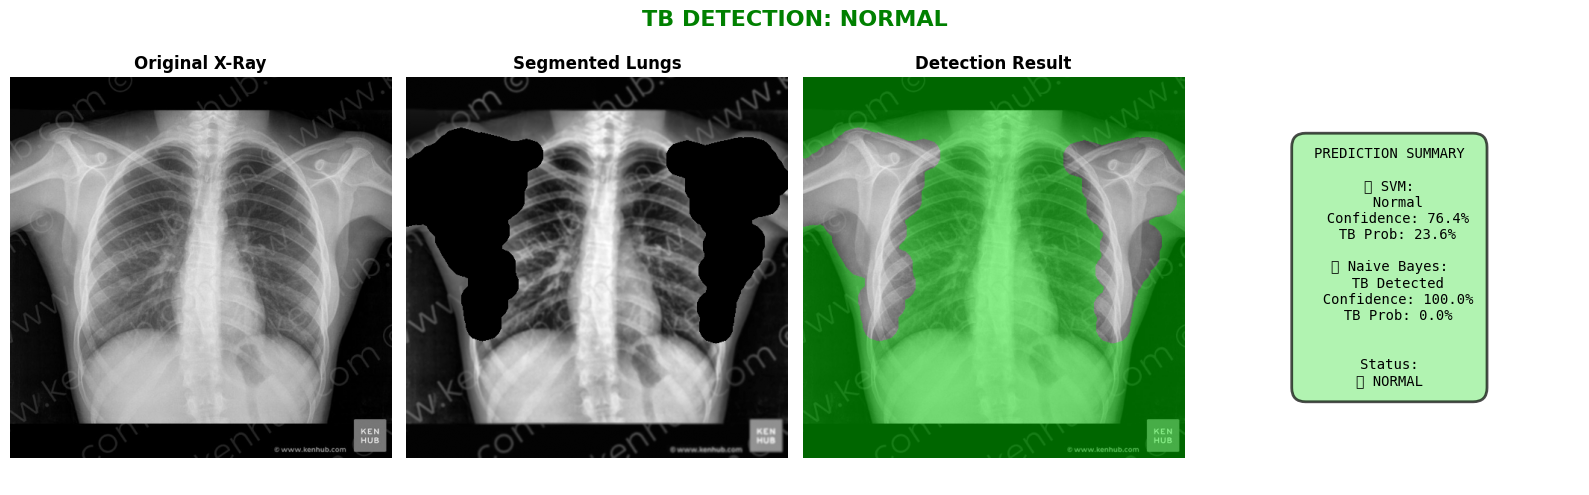

In [27]:
# Run prediction based on configuration
if CONFIG.get('input_type') == '1' and CONFIG.get('image_path'):
    # Single image prediction
    model_choice = CONFIG.get('model_choice', '3')
    
    use_svm = model_choice in ['1', '3'] and svm_model is not None
    use_nb = model_choice in ['2', '3'] and nb_model is not None
    
    result = predict_single_image(
        CONFIG['image_path'],
        svm_model=svm_model if use_svm else None,
        nb_model=nb_model if use_nb else None,
        show_visualization=True
    )

elif CONFIG.get('input_type') == '2' and CONFIG.get('folder_path'):
    # Folder prediction
    model_choice = CONFIG.get('model_choice', '3')
    
    use_svm = model_choice in ['1', '3'] and svm_model is not None
    use_nb = model_choice in ['2', '3'] and nb_model is not None
    
    results_df = predict_folder(
        CONFIG['folder_path'],
        svm_model=svm_model if use_svm else None,
        nb_model=nb_model if use_nb else None
    )
    
    # Optionally save results to CSV
    if results_df is not None:
        save_csv = input("\nSave results to CSV? (y/n): ").strip().lower()
        if save_csv == 'y':
            csv_path = Path(CONFIG['folder_path']) / 'prediction_results.csv'
            results_df.to_csv(csv_path, index=False)
            print(f"\n✅ Results saved to: {csv_path}")

else:
    print("\n⚠️ No valid input provided. Please run the configuration cell again.")